**<font size="6">Script para ordenar el dataset, organizar los conjuntos de entrenamiento y usar image augmentation**</font>

<dl>
<dt>Para obtener los archivos test.csv, train.csv:</dt>
    <dd>- Obtener los archivos MAX_MIN.png y organizarlos en carpetas</dd>
    <dd>- Obtener un archivo dataset.csv con toda la información necesaria para el entrenamiento</dd>
    <dd>- Separar en conjuntos de entrenamiento y validación</dd>
    <dd>- Usar Image Augmentation en el conjunto de entrenamiento para evitar posible sobreajuste del modelo</dd>
</dl>

In [1]:
# Program: <DATASET_CSV.ipynb>
# Author: Marc Bracons Cucó
# Affiliation: Department of Telecommunication and Systems Engineering, Autonomous University of Barcelona, Wireless Information Networking Group
# Copyright © 2023 Marc Bracons Cucó
# 
# This program is proprietary software; you may not use, distribute, or modify it 
# without the explicit permission of the author.
#
# If you wish to use this program in your work, please, contact the author.

**<font size="4">Mover y renombrar archivos MAX_MIN.png a MAX_MIN_frame.png en carpetas _numPaciente</font>**

In [6]:
import os
import shutil

# Definir la ruta base
base_dir = "/home/win001/00_heart/00_Dataset_CNN/02_ALL_FRAMES"
output_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes"

# Recorrer las carpetas MCH y Otros
for category in ["MCH", "Otros"]:
    cat_dir = os.path.join(base_dir, category)
    
    # Recorrer las carpetas de cada paciente
    for patient in os.listdir(cat_dir):
        patient_dir = os.path.join(cat_dir, patient)
        
        # Recorrer las carpetas de frames
        for frame_folder in os.listdir(patient_dir):
            frame_dir = os.path.join(patient_dir, frame_folder)

            # Comprobar si existe MAX_MIN.png antes de renombrar
            old_file_path = os.path.join(frame_dir, "recortes", "MAX_MIN.png")
            if os.path.isfile(old_file_path):
                new_file_name = "MAX_MIN_" + frame_folder.split('_')[-1] + ".png"
                new_file_path = os.path.join(frame_dir, "recortes", new_file_name)
                
                os.rename(old_file_path, new_file_path)
                
                # Crear carpetas de salida si no existen
                new_patient_folder = os.path.join(output_dir, category, patient)
                os.makedirs(new_patient_folder, exist_ok=True)
                
                # Mover los archivos renombrados al nuevo directorio
                shutil.move(new_file_path, new_patient_folder)

print("El proceso ha finalizado con éxito.")

El proceso ha finalizado con éxito.


**<font size="4">Crear archivo dataset.csv con la siguiente información:**</font>
<dl>
    <dt>- image_file: ruta completa de la imagen</dt>
    <dt>- paciente: id del paciente</dt>
    <dt>- frame: frame al que pertenece la imagen</dt>
    <dt>- type: 1 si el paciente tiene MCH, 0 en caso contrario</dt>
</dl>

In [8]:
import os
import csv

# Definir la ruta base y de salida
base_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes"
output_file = os.path.join(base_dir, "dataset.csv")

# Crear y abrir el archivo CSV para escritura
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['image_file', 'paciente', 'frame', 'type']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    # Recorrer las carpetas MCH y Otros
    for category in ["MCH", "Otros"]:
        cat_dir = os.path.join(base_dir, category)
        cat_type = 1 if category == "MCH" else 0
    
        # Recorrer las carpetas de cada paciente
        for patient in os.listdir(cat_dir):
            patient_id = patient.strip('_')  # Eliminar el guion bajo al principio de la id del paciente
            patient_dir = os.path.join(cat_dir, patient)
            
            # Recorrer las carpetas de frames
            for image_file in os.listdir(patient_dir):
                frame_number = image_file.split('_')[-1].strip('.png')  # Extraer el número de frame del nombre del archivo
                image_file_path = os.path.join(patient_dir, image_file)

                # Escribir la información en el archivo CSV
                writer.writerow({'image_file': image_file_path, 'paciente': patient_id, 'frame': frame_number, 'type': cat_type})

print("El archivo CSV ha sido creado exitosamente en la ruta:", output_file)

El archivo CSV ha sido creado exitosamente en la ruta: /home/win001/00_heart/00_Dataset_CNN/02_Recortes/dataset.csv


Miramos las primeras 5 filas del archivo generado:

In [9]:
import pandas as pd

# Ruta del archivo CSV
csv_file = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/dataset.csv"

# Leer el archivo CSV con pandas
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
print(df.head())

                                          image_file  paciente  frame  type
0  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     12     1
1  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     22     1
2  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130      4     1
3  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     10     1
4  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     20     1


**<font size="4">Creamos conjuntos de entrenamiento y test:**</font>
<dl>
<dt>Como tenemos pocas muestras de pacientes no usaremos conjunto de validación, a riesgo de obtener un modelo con sobreajuste</dt>
    <dd>- Conjunto de entrenamiento será del 70% del total</dd>
    <dd>- Conjunto de test será del 30% del total</dt>
    <dd>- Todas las imágenes de un mismo paciente irán a un único conjunto</dd>
    <dd>- el 70% de imágenes destinadas a entrenamiento serán duplicadas usando Image Augmentation</dd>
</dl>

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ruta del archivo CSV
csv_file = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/dataset.csv"

# Leer el archivo CSV con pandas
df = pd.read_csv(csv_file)

# Obtener la lista única de pacientes
pacientes = df['paciente'].unique()

# Dividir la lista de pacientes en train y test
pacientes_train, pacientes_test = train_test_split(pacientes, test_size=0.3, random_state=42)  # 70% train, 30% test

# Crear los conjuntos de train y test
df_train = df[df['paciente'].isin(pacientes_train)]
df_test = df[df['paciente'].isin(pacientes_test)]

# Guardar los conjuntos de train y test como archivos CSV
df_train.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train.csv", index=False)
df_test.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/test.csv", index=False)

print("Los archivos train.csv y test.csv han sido creados exitosamente.")

Los archivos train.csv y test.csv han sido creados exitosamente.


**<font size="4">Ampliación de muestras de entrenamiento usando Image Augmentation:**</font>
<dl> Se aplicarán rotaciones aleatorias a las imágenes</dl>

Aplicamos rotaciones a las imágenes y observamos los resultaos obtenidos

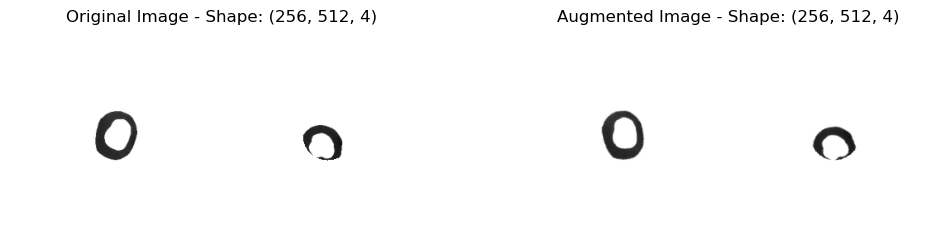

In [37]:
import matplotlib.pyplot as plt
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import imgaug as ia

# Carga la imagen
image_path = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/MCH/_3/MAX_MIN_10.png"
image = np.array(Image.open(image_path))

# Divide la imagen en dos mitades
half = int(image.shape[1] / 2)
left_half = image[:, :half]
right_half = image[:, half:]

# Crea una secuencia de aumentación con una rotación aleatoria
degree = np.random.uniform(45, 360)  # Cambia el rango según tus necesidades
aug = iaa.Affine(rotate=degree)

# Aplica la misma rotación a ambas mitades
left_half_aug = aug(image=left_half)
right_half_aug = aug(image=right_half)

# Vuelve a unir las dos mitades
image_aug = np.concatenate((left_half_aug, right_half_aug), axis=1)

# Mostrar la imagen original y la aumentada
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title("Original Image - Shape: " + str(image.shape))
ax[0].axis("off")

ax[1].imshow(image_aug)
ax[1].set_title("Augmented Image - Shape: " + str(image_aug.shape))
ax[1].axis("off")

plt.show()

Aplicamos los cambios a todas las imágenes de train.csv

In [32]:
import os
import pandas as pd
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import imgaug as ia

# Ruta del archivo CSV
csv_file = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train.csv"

# Directorio de salida
output_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/Image Augmentation"

# Leer el archivo CSV
df = pd.read_csv(csv_file)

# Crea una secuencia de aumentación con una rotación aleatoria
aug = iaa.Affine(rotate=(-360, 360))

# Recorre todas las filas del DataFrame
for index, row in df.iterrows():
    # Carga la imagen
    image_path = row["image_file"]
    image = np.array(Image.open(image_path))

    # Divide la imagen en dos mitades
    half = int(image.shape[1] / 2)
    left_half = image[:, :half]
    right_half = image[:, half:]

    # Aplica la misma rotación a ambas mitades
    left_half_aug = aug(image=left_half)
    right_half_aug = aug(image=right_half)

    # Vuelve a unir las dos mitades
    image_aug = np.concatenate((left_half_aug, right_half_aug), axis=1)

    # Crear directorios de salida si no existen
    patient_id = row["paciente"]
    category = "aug_MCH" if row["type"] == 1 else "aug_Otros"
    patient_folder = os.path.join(output_dir, category, f"_{patient_id}")
    os.makedirs(patient_folder, exist_ok=True)

    # Guarda la imagen transformada
    output_path = os.path.join(patient_folder, "rot_" + os.path.basename(image_path))
    Image.fromarray(image_aug).save(output_path)

**<font size="4">Obtención de train_full.csv con las imagenes originales y las transformadas**</font>
<dl>
<dt>Se generará un archivo train_aug.csv con las imágenes transformadas</dt>
<dt>Se fusionarán train.csv y train_aug.csv</dt>
    <dd>- Para evitar duplicar las ID de los pacientes, a los obtenidos con las rotaciones se les sumará "99990000"</dd>
</dl>

Generamos train_aug.csv

In [33]:
import os
import pandas as pd

# Ruta del directorio de las nuevas imágenes
image_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/Image Augmentation"

# Crear una lista para almacenar las filas del archivo CSV
data = []

# Recorrer los directorios de las categorías
for category in os.listdir(image_dir):
    category_dir = os.path.join(image_dir, category)

    # Recorrer los directorios de los pacientes
    for patient in os.listdir(category_dir):
        patient_dir = os.path.join(category_dir, patient)

        # Recorrer los archivos de imagen
        for image_file in os.listdir(patient_dir):
            # Obtener la ruta completa del archivo de imagen
            image_file_path = os.path.join(patient_dir, image_file)

            # Obtener el ID del paciente sumando 99990000
            patient_id = int(patient.lstrip('_')) + 99990000

            # Obtener el número de frame del nombre del archivo de imagen
            frame = int(image_file.split('_')[-1].split('.')[0])

            # Asignar 1 si pertenece a "aug_MCH", 0 si pertenece a "aug_Otros"
            type = 1 if category == "aug_MCH" else 0

            # Agregar la fila al archivo CSV
            data.append([image_file_path, patient_id, frame, type])

# Crear un DataFrame a partir de la lista de datos
df = pd.DataFrame(data, columns=["image_file", "paciente", "frame", "type"])

# Guardar el DataFrame en un archivo CSV
df.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_aug.csv", index=False)

In [34]:
import pandas as pd

# Ruta del archivo CSV
csv_file = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_aug.csv"

# Leer el archivo CSV con pandas
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
print(df.head())

                                          image_file  paciente  frame  type
0  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  99990123     13     0
1  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  99990123      1     0
2  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  99990123      7     0
3  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  99990123      2     0
4  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  99990123      4     0


Fusionamos train.csv y train_aug.csv para obtener train_full.csv

In [35]:
import pandas as pd

# Leer los archivos CSV
train = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train.csv")
train_aug = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_aug.csv")

# Concatenar los DataFrames
train_full = pd.concat([train, train_aug])

# Guardar el DataFrame en un archivo CSV
train_full.to_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_full.csv", index=False)

Contamos el número de pacientes únicos en cada dataset de entrenamiento

In [36]:
import pandas as pd

# Leer los archivos CSV
train = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train.csv")
train_aug = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_aug.csv")
train_full = pd.read_csv("/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_full.csv")

# Contar el número de pacientes únicos en cada DataFrame
num_unique_patients_train = train['paciente'].nunique()
num_unique_patients_train_aug = train_aug['paciente'].nunique()
num_unique_patients_train_full = train_full['paciente'].nunique()

print(f"Number of unique patients in train.csv: {num_unique_patients_train}")
print(f"Number of unique patients in train_aug.csv: {num_unique_patients_train_aug}")
print(f"Number of unique patients in train_full.csv: {num_unique_patients_train_full}")

Number of unique patients in train.csv: 31
Number of unique patients in train_aug.csv: 31
Number of unique patients in train_full.csv: 62


**<font size="4">Modificaremos el formato de las imágenes de RGBA a RGB para poder entrenar los modelos con pesos pre-entrenados</font>**

In [39]:
import os
import pandas as pd
from PIL import Image

# Directorio de los archivos CSV
csv_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes"

# Archivos CSV a procesar
csv_files = ["train_aug.csv", "dataset.csv"]

# Recorrer los archivos CSV
for csv_file in csv_files:
    # Ruta completa del archivo CSV
    csv_path = os.path.join(csv_dir, csv_file)

    # Leer el archivo CSV
    df = pd.read_csv(csv_path)

    # Recorrer las filas del DataFrame
    for index, row in df.iterrows():
        # Obtener la ruta completa de la imagen
        image_path = row["image_file"]

        # Cargar la imagen
        image = Image.open(image_path)

        # Convertir la imagen de RGBA a RGB
        image = image.convert("RGB")

        # Generar el nuevo nombre de archivo con el prefijo "RGB_"
        file_name = os.path.basename(image_path)
        new_file_name = "RGB_" + file_name

        # Construir la ruta de salida con el mismo directorio y el nuevo nombre de archivo
        output_path = os.path.join(os.path.dirname(image_path), new_file_name)

        # Guardar la imagen modificada
        image.save(output_path)

    print(f"Imágenes convertidas y guardadas en formato RGB para el archivo {csv_file}.")

print("Proceso completado.")

Imágenes convertidas y guardadas en formato RGB para el archivo train_aug.csv.
Imágenes convertidas y guardadas en formato RGB para el archivo dataset.csv.
Proceso completado.


Actualizamos los archivos csv

In [40]:
import os
import pandas as pd

# Ruta de los archivos CSV
csv_dir = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes"

# Archivos CSV a procesar
csv_files = ["train_full.csv", "test.csv"]

# Recorrer los archivos CSV
for csv_file in csv_files:
    # Ruta completa del archivo CSV
    csv_path = os.path.join(csv_dir, csv_file)

    # Leer el archivo CSV
    df = pd.read_csv(csv_path)

    # Agregar la columna "RGB_file" con los nombres de archivo modificados
    df["RGB_file"] = df["image_file"].apply(lambda x: os.path.join(os.path.dirname(x), "RGB_" + os.path.basename(x)))

    # Guardar el DataFrame modificado en el mismo archivo CSV
    df.to_csv(csv_path, index=False)

    print(f"Columna 'RGB_file' agregada al archivo {csv_file}.")

print("Proceso completado.")

Columna 'RGB_file' agregada al archivo train_full.csv.
Columna 'RGB_file' agregada al archivo test.csv.
Proceso completado.


In [41]:
import pandas as pd

# Ruta del archivo CSV
csv_file = "/home/win001/00_heart/00_Dataset_CNN/02_Recortes/train_full.csv"

# Leer el archivo CSV con pandas
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
print(df.head())

                                          image_file  paciente  frame  type  \
0  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     12     1   
1  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     22     1   
2  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130      4     1   
3  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     10     1   
4  /home/win001/00_heart/00_Dataset_CNN/02_Recort...       130     20     1   

                                            RGB_file  
0  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  
1  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  
2  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  
3  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  
4  /home/win001/00_heart/00_Dataset_CNN/02_Recort...  
